Collecting data from different sources for a set of addresses (we can provide you with sample addresses but feel free to find interesting groups of wallets
which are publicly available); 

the data to be collected by the list of wallets will
include transactions, tokentransfers, balance/token balance

In [1]:
## import libraries
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import requests
import seaborn as sns
import sys
import time

In [2]:
## set seaborn style for plots
sns.set_theme()

In [3]:
## load data
balances = pd.read_csv('../data/balances.csv')
normal_transactions = pd.read_csv('../data/normal_transactions.csv')
token_transactions = pd.read_csv('../data/token_transactions.csv')
token_balances = pd.read_csv('../data/token_balances.csv')

In [4]:
## data type cleaning
normal_transactions['Value'] = normal_transactions['Value'].apply(int)
normal_transactions['Datetime'] = pd.to_datetime(normal_transactions['Timestamp'], unit='s')

token_transactions['Value'] = token_transactions['Value'].apply(int)
token_transactions['Datetime'] = pd.to_datetime(token_transactions['Timestamp'], unit='s')
link_transactions = token_transactions[token_transactions['TokenSymbol']=='LINK']
link_balances = token_balances[token_balances['TokenSymbol']=='LINK']

In [5]:
## compute direction of transfer (in/out)
link_transactions['Inbound'] = 1*(link_transactions['Address'].str.lower() \
                                  == link_transactions['To'].str.lower())
link_transactions['Outbound'] = 1*(link_transactions['Address'].str.lower() \
                                   == link_transactions['From'].str.lower())

In [6]:
# ## plot time series of each address
# n_addresses = link_transactions['Name'].nunique()
# fig, ax = plt.subplots(nrows=int(np.ceil(n_addresses/4)), 
#                        ncols=4, figsize=(15,24), squeeze=True)
# ax = ax.ravel()
# for idx, account in enumerate(link_transactions['Name'].unique()):
#     subset = link_transactions[link_transactions['Name']==account]
#     colors = ['limegreen' if inbound else 'red' for inbound in subset['Inbound'].values]
#     subset.plot(x='Datetime', y='Value', ax=ax[idx], kind='scatter', color=colors, xlabel=None, ylabel=None)
#     ax[idx].xaxis.set_tick_params(rotation=45)
#     ax[idx].set_title(account)

# plt.tight_layout()
# plt.show()

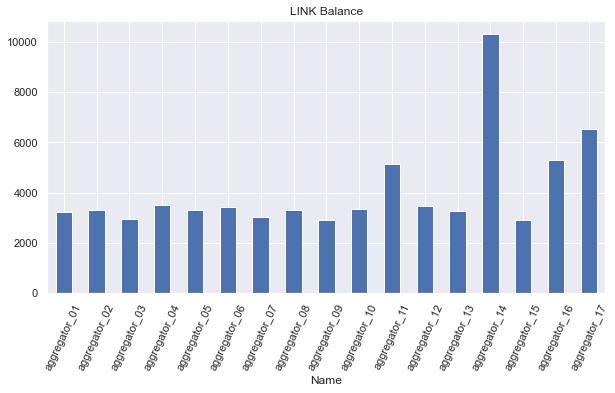

In [7]:
## plot by LINK balance
link_balances['TokenBalanceFloat'] = link_balances['TokenBalance'].apply(float)
link_balances['TokenBalanceDecimal'] = link_balances['TokenBalanceFloat']/10**18
link_balances.plot.bar(x='Name', y='TokenBalanceDecimal', figsize=(10,5), rot=65, legend=False,
                       title='LINK Balance')
plt.show()

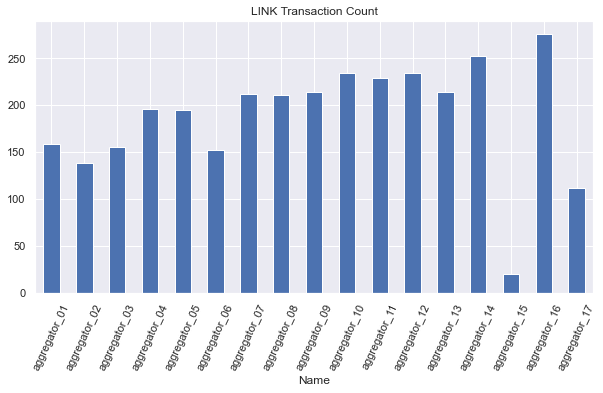

In [8]:
## plot by count of LINK transactions
link_transaction_counts = link_transactions.groupby('Name')['TokenName'].count()
link_transaction_counts.plot.bar(x='Name', y='TokenBalanceDecimal', figsize=(10,5), rot=65, legend=False,
                       title='LINK Transaction Count')
plt.show()

<ipython-input-9-e91fb05e48c7>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(cleaned_link_transactions.groupby('Name')['TimeSinceLastTxn'].mean().index, rotation=65)


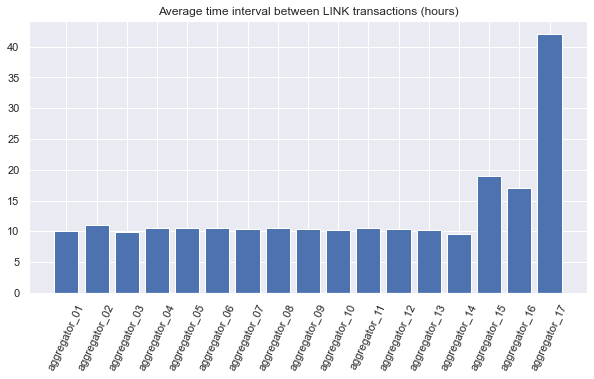

In [9]:
## plot of average interval between LINK transactions
link_transactions['TimeSinceLastTxn'] = link_transactions.sort_values(['Name', 'Datetime']) \
    .groupby(['Name'])['Datetime'].diff()
cleaned_link_transactions = link_transactions.dropna(subset=['TimeSinceLastTxn'])

interval_between_link_transactions_seconds = cleaned_link_transactions.groupby('Name')['TimeSinceLastTxn'] \
    .mean().values.astype(float)/10**9
interval_between_link_transactions_hours = interval_between_link_transactions_seconds/(60*60)

fig, ax = plt.subplots(1,1,figsize=(10,5))
ax.bar(height=interval_between_link_transactions_hours,
       x=cleaned_link_transactions.groupby('Name')['TimeSinceLastTxn'].mean().index)
ax.set_xticklabels(cleaned_link_transactions.groupby('Name')['TimeSinceLastTxn'].mean().index, rotation=65)
ax.set_title('Average time interval between LINK transactions (hours)')
plt.show()

<ipython-input-10-608d11e6e43c>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(cleaned_normal_transactions.groupby('Name')['TimeSinceLastTxn'].mean().index, rotation=65)


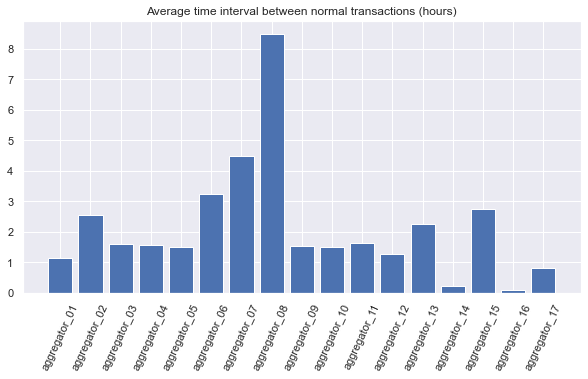

In [10]:
## plot of average interval between normal transactions
normal_transactions['TimeSinceLastTxn'] = normal_transactions.sort_values(['Name', 'Datetime']) \
    .groupby(['Name'])['Datetime'].diff()
cleaned_normal_transactions = normal_transactions.dropna(subset=['TimeSinceLastTxn'])

interval_between_normal_transactions_seconds = cleaned_normal_transactions.groupby('Name')['TimeSinceLastTxn'] \
    .mean().values.astype(float)/10**9
interval_between_normal_transactions_hours = interval_between_normal_transactions_seconds/(60*60)

fig, ax = plt.subplots(1,1,figsize=(10,5))
ax.bar(height=interval_between_normal_transactions_hours,
       x=cleaned_normal_transactions.groupby('Name')['TimeSinceLastTxn'].mean().index)
ax.set_xticklabels(cleaned_normal_transactions.groupby('Name')['TimeSinceLastTxn'].mean().index, rotation=65)
ax.set_title('Average time interval between normal transactions (hours)')
plt.show()

In [11]:
## compute balance over time
link_transactions['SignedValue'] = link_transactions.apply(
    lambda x: x['Value']*(x['Inbound']-x['Outbound']), axis=1).astype('float64')
link_transactions['SignedValueDecimal'] = link_transactions['SignedValue']/10**18
link_transactions['RunningBalance'] = link_transactions.groupby('Name')['SignedValue'].cumsum()
link_transactions['RunningBalanceDecimal'] = link_transactions['RunningBalance']/10**18

# confirm running balance sums to current balance
np.allclose(link_balances['TokenBalance'].astype('float64').values,
            link_transactions.groupby('Name')['RunningBalance'].agg('last').values,
           )

True

<ipython-input-12-f447351dcd2d>:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  for group in link_transactions.groupby('Name')['RunningBalanceDecimal', 'Datetime']:


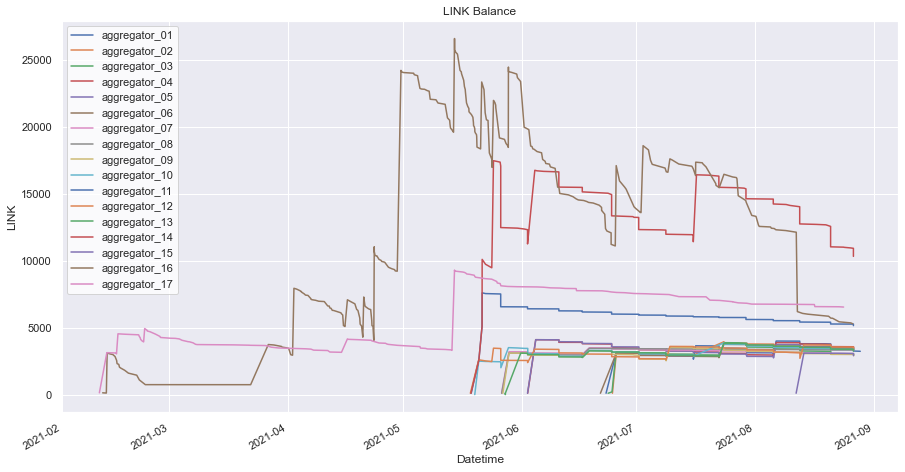

In [12]:
## plot running balance
fig, ax = plt.subplots(1,1,figsize=(15,8))

for group in link_transactions.groupby('Name')['RunningBalanceDecimal', 'Datetime']:
    group[1].plot(x='Datetime', y='RunningBalanceDecimal', ax=ax, label=group[1]['Name'].values[0])
    
ax.legend(facecolor='white')
ax.set_ylabel('LINK')
ax.set_title('LINK Balance')

plt.show()

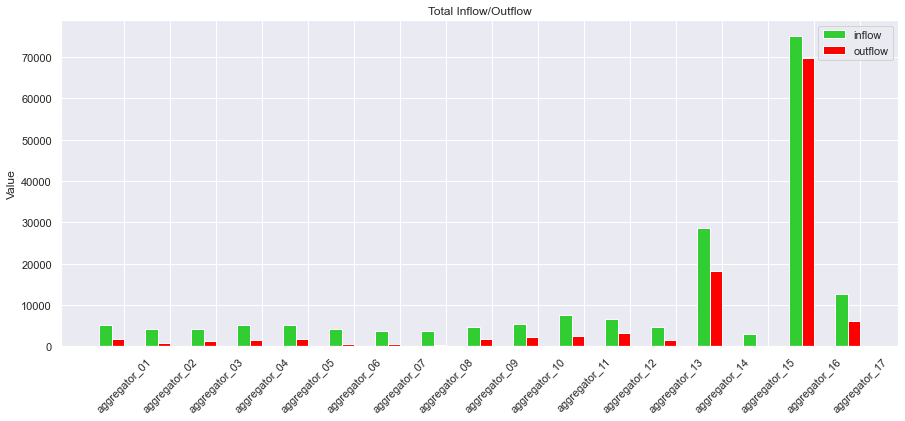

In [13]:
## sum of income vs spend (twin bar plot)
total_inflow = link_transactions[link_transactions['Inbound'] == 1] \
    .groupby('Name')['SignedValue'].sum() / 10**18
total_outflow = link_transactions[link_transactions['Outbound'] == 1] \
    .groupby('Name')['SignedValue'].sum().apply(abs) / 10**18
fig, ax = plt.subplots(1,1,figsize=(15,6))

num_addresses = len(total_inflow)
indices = np.arange(num_addresses)
width = 0.27

rects1 = ax.bar(indices-width/2, total_inflow.values, width, color='limegreen')
rects2 = ax.bar(indices+width/2, total_outflow.values, width, color='red')

ax.set_ylabel('Value')
ax.set_xticks(indices+width)
ax.set_xticklabels(total_inflow.index.values)
ax.xaxis.set_tick_params(rotation=45)
ax.legend((rects1[0], rects2[0]),('inflow', 'outflow'))
ax.set_title('Total Inflow/Outflow')
plt.show()

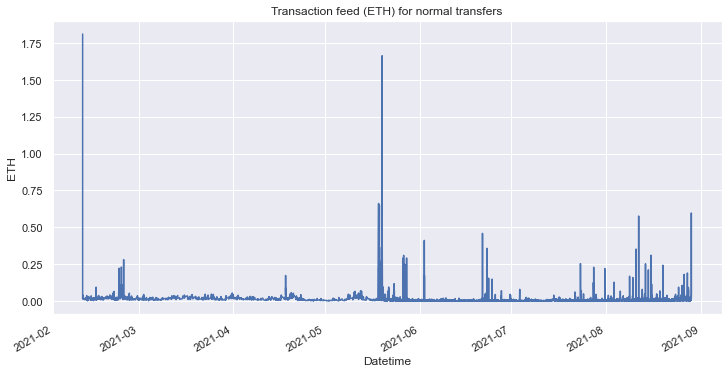

In [14]:
## transaction fees for normal transactions
normal_transactions['TransactionFeeEthDecimal'] = normal_transactions['TransactionFeeEth']/10**18
ax = normal_transactions.plot(x='Datetime', y='TransactionFeeEthDecimal', figsize=(12,6), ylabel='ETH',
                            title='Transaction feed (ETH) for normal transfers', legend=False)
plt.show()

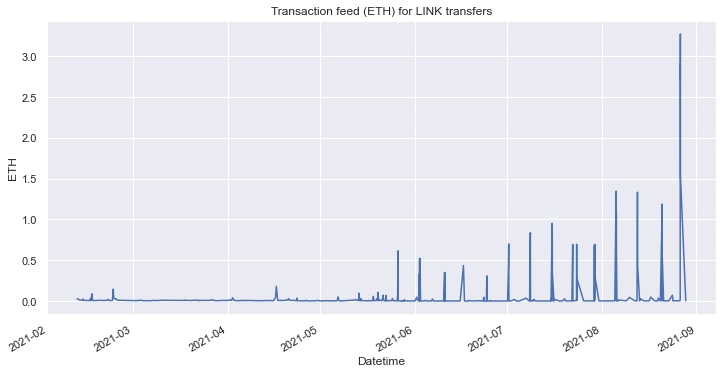

In [15]:
## transaction fees for LINK transfers
link_transactions['TransactionFeeEthDecimal'] = link_transactions['TransactionFeeEth'] / 10**18
ax = link_transactions.plot(x='Datetime', y='TransactionFeeEthDecimal', figsize=(12,6), ylabel='ETH',
                            title='Transaction feed (ETH) for LINK transfers', legend=False)
plt.show()

In [16]:
## save processed data
link_transactions.to_csv('../data/link_transactions.csv', index=False, header=True)
# - running balance
# - transaction fees
# - compute total inflow/outflow
# - compute current balance